In [1]:
from concise.hyopt import CMongoTrials, get_data
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import data

%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

def print_exp(exp_name):
    print("-" * 40 + "\nexp_name: " + exp_name)


DIR_ROOT = "/s/project/deepcis/encode/eclip/"
#DIR_ROOT = "/home/avsec/projects-work/deepcis/data/encode/eclip/"
RBP_LIST = ["UPF1", "PUM2", "DDX3X", "NKRF", "TARDBP", "SUGP2"]

DB_NAME = "RBP__Eclip"
HOST = "ouga03"
#HOST = "localhost"

#EXPERIMENTS = ["DeepNN",
#               "DeepNN_scalar_position_gam",
#               "DeepNN_scalar_position_relu",
#               "DeepNN_track_position_gam",
#               "DeepNN_track_position_relu"]
EXPERIMENTS = ["DeepNN_scalar_position_gam_2",
               "DeepNN_scalar_position_relu_2"]
data_fn = data.data


Using TensorFlow backend.


In [2]:
from concise.hyopt import get_data

In [8]:
from tempfile import mkdtemp
from joblib import Memory


memory = Memory(cachedir=DIR_ROOT + "/cache", verbose=0)

In [9]:
def get_best_model(rbp, exp_name):
    trials = CMongoTrials(DB_NAME, exp_name + "_" + rbp, ip=HOST)
    tid = trials.best_trial_tid()
    param = trials.get_param(tid)
    return trials.load_model(tid), param

In [10]:
def get_new_train(train, xr, which):
    from copy import deepcopy
    def get_new_train_one(i, train, xr, which):
        xtrain = deepcopy(train)
        xrval = xr[i][np.newaxis]
        xrval = np.repeat(xrval, train[1].shape[0], axis=0)
        xtrain[0][which] = xrval
        return xtrain
    return [get_new_train_one(i, train, xr, which) for i in range(xr.shape[0])]

In [11]:
@memory.cache
def get_predictions(rbp_name, exp_name, num_eval=50):
    from concise.preprocessing import encodeSplines
    from copy import deepcopy
    print("get model")
    m, param = get_best_model(rbp_name, exp_name)
    print("get data")
    train, valid, test = get_data(data.data, param)
    tss_pos_ranges, polya_pos_ranges = train[3:5]
    
    ## TODO - change this back to 0,1 range and then back to -min, max range
    #tss_xr = np.linspace(np.log10(tss_pos_ranges["min"]), np.log10(tss_pos_ranges["max"]), num=num_eval)
    tss_xr = np.linspace(0, 1, num=num_eval)
    #polya_xr = np.linspace(np.log10(polya_pos_ranges["min"]), np.log10(polya_pos_ranges["max"]), num=num_eval)
    polya_xr = np.linspace(0, 1, num=num_eval)

    print("process positions")    
    pos_type=exp_name.split("_")[-2]
    if pos_type == "gam":
        which_tss = "dist_tss_log"
        which_polya= "dist_polya_log"
        n_bases = train[0]["dist_tss_nat"].shape[2]
        tss_xr_feat = encodeSplines(tss_xr, n_bases=n_bases, start = 0, end = 1)
        polya_xr_feat = encodeSplines(polya_xr, n_bases=n_bases, 
                                      start = 0, end = 1)
    elif pos_type == "relu":
        which_tss = "raw_dist_tss_log"
        which_polya= "raw_dist_polya_log"
        tss_xr_feat = tss_xr[:, np.newaxis, np.newaxis]
        polya_xr_feat = polya_xr[:, np.newaxis, np.newaxis]
    else:
        raise Exception
    
    print("get tss data")
    tss_train_list = get_new_train(train, tss_xr_feat, which_tss)
    print("get polya data")
    polya_train_list = get_new_train(train, polya_xr_feat, which_polya)
    
    print("predict for tss")
    tss_preds = np.stack([m.predict(train_xp[0]) for train_xp in tss_train_list])
    print("predict for polya")
    polya_preds = np.stack([m.predict(train_xp[0]) for train_xp in polya_train_list])
    
    df = pd.DataFrame({"tss_x": tss_xr,
                  "tss_y": tss_preds.mean(1).reshape((-1)),
                  "polya_x": polya_xr,
                  "polya_y": polya_preds.mean(1).reshape((-1)),
                 }).assign(rbp=rbp_name, exp=exp_name) 
    return df

        
    

In [24]:
df_gam = get_predictions("UPF1", EXPERIMENTS[0], 50)
df_relu = get_predictions("UPF1", EXPERIMENTS[1], 50)

get model


KeyboardInterrupt: 

In [25]:
from joblib import Parallel, delayed

In [28]:
dt_pos_all = pd.concat(Parallel(n_jobs=12)(delayed(get_predictions)(rbp, exp, 50) 
                        for rbp in tqdm(RBP_LIST)
                        for exp in tqdm(EXPERIMENTS)))

get model
get model
get model
get model
get model
get model
get model
get model
get model
get model
get model
get model


KeyboardInterrupt: 

In [12]:
dt_pos_all = pd.concat([get_predictions(rbp, exp, 50) 
                        for rbp in tqdm(RBP_LIST)
                        for exp in tqdm(EXPERIMENTS)])

get model
get data
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
process positions
get tss data
get polya data
predict for tss
predict for polya
get model
get data
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating

In [13]:
dt_pos_all.to_csv(DIR_ROOT + "/processed/partial_dependence.csv")

In [13]:
from ggplot import *

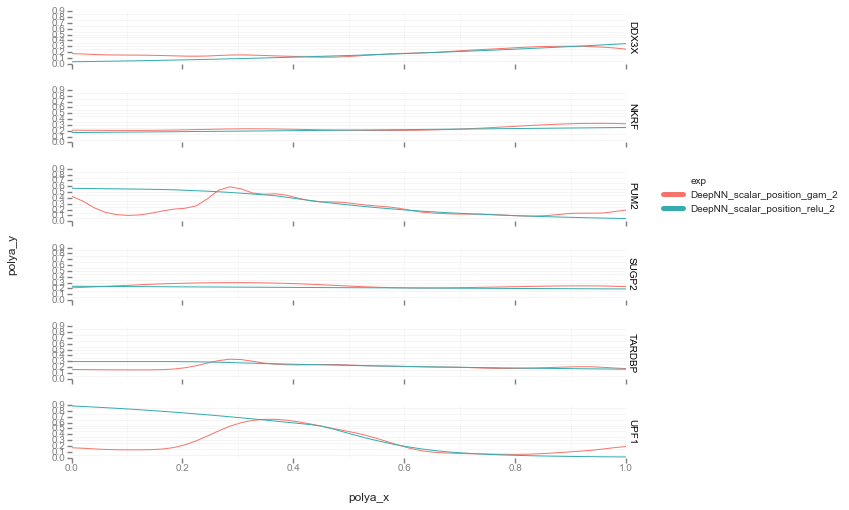

<ggplot: (8783093240924)>

In [21]:
ggplot(aes(x = "polya_x", y = "polya_y", color = "exp"), data=dt_pos_all) + \
    geom_line()+\
    facet_grid(x="rbp") D

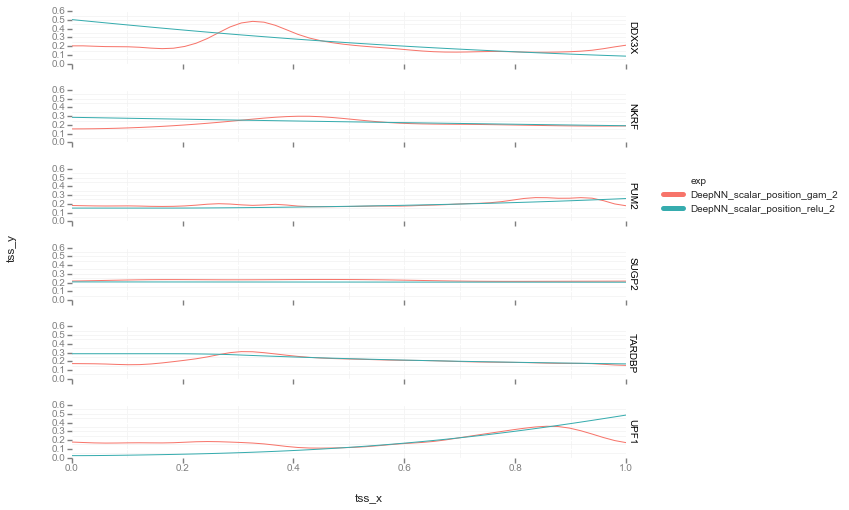

<ggplot: (8783092851755)>

In [25]:
ggplot(aes(x = "tss_x", y = "tss_y", color = "exp"), data=dt_pos_all) + \
    geom_line()+\
    facet_grid(x="rbp") + theme_bw()

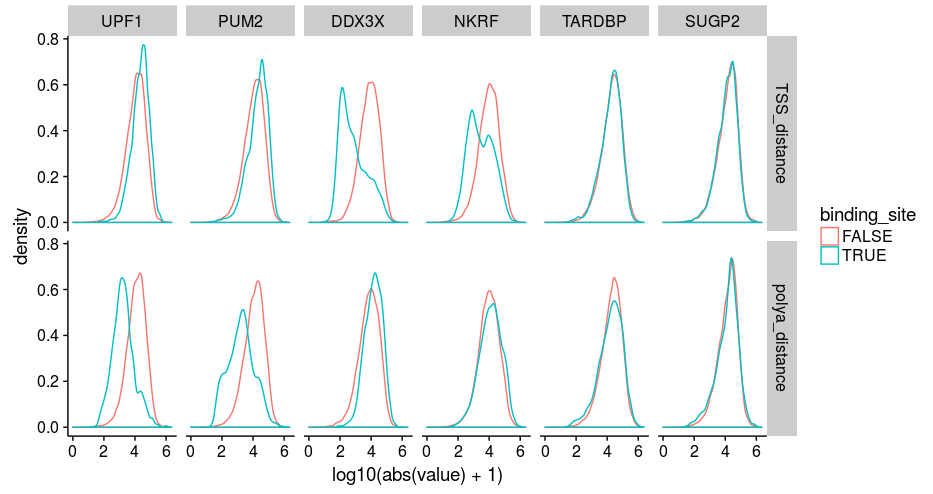

In [18]:
from IPython.display import Image
Image(filename='/data/ouga/home/ag_gagneur/avsec/projects-work/deepcis/data/plots/RBP/Eclip/position_screenshot.png')